# Implementation of an autoencoder in TensorFlow
---

__This page can be downloaded as__ [interactive jupyter notebook](./Autoencoder.ipynb).

---
This notebook deals with the concept of using an Autoencoder for compression and reconstruction of images. Furthermore, this tutorial is an introduction to the basic concepts of the Deep Learning Framework __TensorFlow__. The tutorial consists of 3 parts:
1. What is an Autoencoder? 
2. Implementation of an Autoencoder for image compression.
3. Analysis of several hyper-parameters of the model and their influence.

## Part 1: What is an Autoencoder?
Autoencoder denotes a specific group of models that learn a mapping from any input to the input itself. The main concept is to have a $\color{green}{\text{Latent Layer}}$ bottleneck along the network, where the input is forced to be represented in a lower dimensional space. The part of the network that maps the input to the lower-dimensional latent representation is usually called $\color{green}{\text{Encoder}}$ while the $\color{green}{\text{Decoder}}$ denotes the part of the network, that recreates the input based on the latent representation.
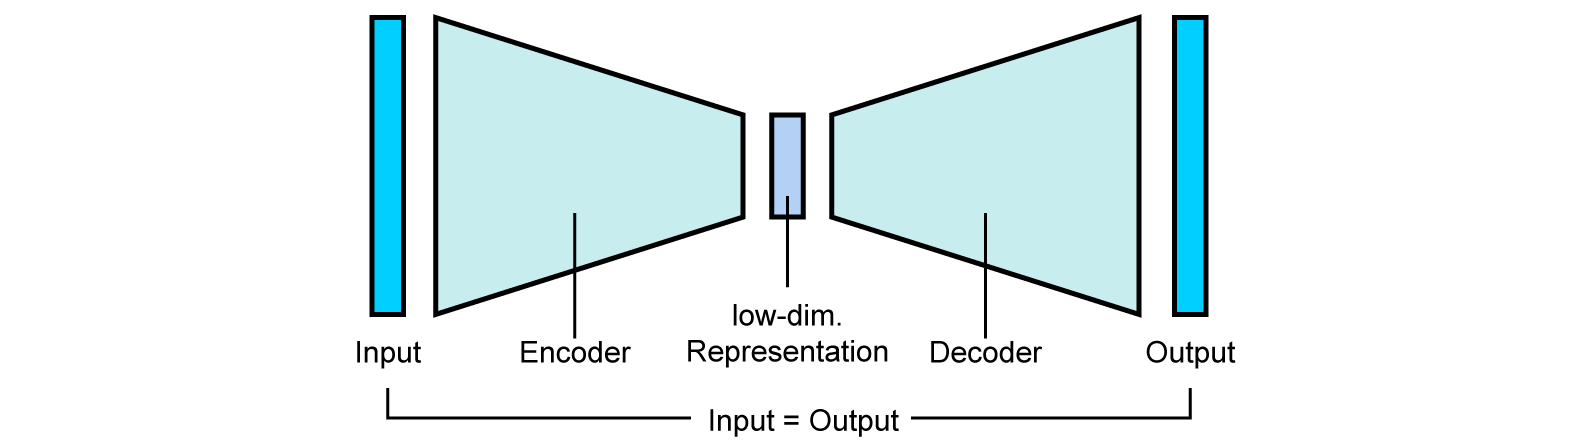
Any autoencoder is trained by minimizing the $\color{green}{\text{Reconstruction Loss }}$ which is used to measure how close the output is to the input. Thus, the training does not require any labels, which makes the training unsupervised.

The design of an autoencoder architecture strongly depends on its purpose. Besides the autoencoders, which are used to create low-dimensional representations (e.g. for data compression) there are autoencoders for denoising, anomaly detection, image-colorization and many more. In this tutorial, we give an example of a simple stacked (multi-layer) autoencoder which is used to reconstruct an image. 

## Part 2: Implementation of an autoencoder for image compression
In this part, we will show how a stacked autoencoder can be used to compress and reconstruct images (here from the MNIST dataset). The implementation is based on TensorFlow. The main steps to build a stacked autoencoder are:
1. Image Preprocessing
2. Building a TensorFlow data pipeline
3. Define the model (graph)
4. Train the model (session)
5. Validation of the model
6. Evaluate the model
7. Analysis on compression ratio

### Part 2.1 Image Preprocessing
For the image preprocessing part, we import numpy and Tensorflow, and as well as the MNISt dataset first. MNIST is a labeled set of images of handwritten digits. 

#### Downloading the data

The code below is used to download the MNIST dataset (Code borrowed from a Tensorflow tutorial)


In [22]:
import os
from six.moves.urllib.request import urlretrieve

SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
WORK_DIRECTORY = "/tmp/mnist-data"

def maybe_download(filename):
    """A helper to download the data files if not present."""
    if not os.path.exists(WORK_DIRECTORY):
        os.mkdir(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urlretrieve(SOURCE_URL + filename, filepath)
        statinfo = os.stat(filepath)
        print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    else:
        print('Already downloaded', filename)
    return filepath

train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

Already downloaded train-images-idx3-ubyte.gz
Already downloaded train-labels-idx1-ubyte.gz
Already downloaded t10k-images-idx3-ubyte.gz
Already downloaded t10k-labels-idx1-ubyte.gz


#### Data normalization 

Up to now, we have the files. Since the data is zipped, it needs to be decompressed. Then, we would have training and testing dataset. One part of training dataset will be used as validation dataset. Also, each of the images are encoded with in the gray value range from [0,255] and have a size of 28 x 28 pixels. Before feeding them into the network, we want to normalize the pixel values to a range of [0,1]. 

Extracting /tmp/mnist-data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist-data/t10k-images-idx3-ubyte.gz
Training data shape (55000, 784)
Validation data shape (5000, 784)
Test data shape (10000, 784)


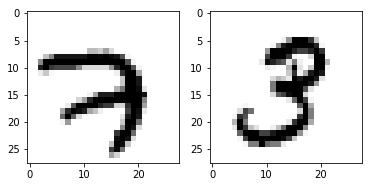

In [23]:
IMAGE_SIZE = 28
PIXEL_DEPTH = 255

import gzip, binascii, struct, numpy
import matplotlib.pyplot as plt

def extract_data(filename, num_images):
    """ Extract the images into a 3D tensor [image index, y, x]. """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        """ Skip the magic number and dimensions; we know these values."""
        bytestream.read(16)

        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images)
        data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
        data = data / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE*IMAGE_SIZE)
        return data

validation_size = 5000

Data = extract_data(train_data_filename, 60000)
train_data = Data[validation_size:, :]
validation_data = Data[:validation_size, :]
test_data = extract_data(test_data_filename, 10000)

print('Training data shape', train_data.shape)
print('Validation data shape',validation_data.shape)
print('Test data shape',test_data.shape)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(train_data[0].reshape(28, 28), cmap=plt.cm.Greys)
ax2.imshow(train_data[1].reshape(28, 28), cmap=plt.cm.Greys)

### Part 2.2 Building a TensorFlow data pipeline

Now the data is ready to be used. Next, we start to use TensorFlow. In TensorFlow, all the computations are based on tensors. A tensor, represents data like arrays or (multidimensional) matrice. The next step is to think about how should we feed this huge amount of data into the computation. Obviously, we can't apply this feeding process of the data once and all. 
The idea is to create a $\color{green}{\text{placeholder}}$ which is one type of tensor that acts as data input for the model. 
After creating a placeholder, the next step is to feed a placeholder with actual data, which will iterate over the dataset in each training iteration. 
In TensorFlow, this is implemented via the $\color{green}{\text{Dataset class}}$ which populates the value of the placeholder during training and inference. 
As mentioned, the ingoing data to the placeholder must change every time to make sure that we feed all the dataset one after one. And, this flowing of data one after one is realized by $\color{green}{\text{pipeline}}$ with an $\color{green}{\text{iterator}}$. 

We will walk through this part and explain in more details by showing the code for 

- creating the placeholder
- using the dataset class
- creating the pipeline

**create the placeholder**

In [24]:
import numpy as np
import tensorflow as tf

""" Below code prevents: Kernel restarting error"""

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

size_inputs = 28*28 # number of pixels of a mnist image

""" using a placeholder for BATCH_SIZE which is no.of images feed with the pipeline in each iteration"""

batch_size = tf.placeholder(tf.int64)

""" using a placeholder for dataset, the input image """

x = tf.placeholder(tf.float32,shape = [None, size_inputs])

#### using the dataset class

The TF class ``Dataset`` implements the iteration over the used training samples, cares about data shuffling as well as batch creation. The function `tf.data.Dataset.from_tensor_slices` is used to create a `tf.data.Dataset` object which represents slices of our data. The data is sliced across its first dimension. In our case the input data is a stacked matrix of all the MNIST training set images. This matrix has a shape of (60000,28,28). The function `from_tensor_slices()` generates a Dataset object which contains 60000 slices in total, each one corresponding to a 28 x 28 image. The second function `tf.Dataset.repeat(count=None)` will create a indefinitely loop over this data. The function `tf.data.Dataset.batch` selects a number of slices and stacks them to build batches. If the batch_size is 94, then the size of each batch is (94,28,28,1). The last dimensions corresponds to the channels per image (which is 1 in our case). 

In [25]:
""" This results in a Dataset containing 3D arrays representing stacks of (28,28) images: """

dataset = tf.data.Dataset.from_tensor_slices(x).repeat().batch(batch_size)

#### create the pipeline

Lastly, we have to initialize an iterable tensor. Running the tensor `features` in a session will deliver a batch instance.

In [26]:
iterator = dataset.make_initializable_iterator()
features = iterator.get_next()

### Part 2.3 Define the mode (graph)
Up to now, we have the input and the pipeline for feeding the network with batches of the data. The next step is to implement the stacked autoencoder. As introduced before, an autoencoder has multiple hidden layers. After input is $\color{green}{\text{top hidden layer 1}}$,then $\color{green}{\text{middle layer 2 }}$and  $\color{green}{\text{top hidden layer 3}}$ before output. Encoding happens at the process from top hidden layer 1 to middle layer 2. Decoding refers to the process between middle layer 2 to the top hidden layer 3. This part contains follow two steps:
<br> **define the parameters**
<br> **define the model**

**define the parameters**

Like in any other deep learning model the autoencoder requires the number of neurons for each layer in advance. The number of neurons (and number of hidden layers) will affect the capacity of the network. Higher capacity means, that more complex mappings (or here: representations)can be learned, but higher capacity also increases the chance of overfitting and requires more data to be trained. 

In [27]:
size_hidden_1 = 10000 

# this is the bottleneck. 
# In order to achieve a compression, the number
# of neurons must be smaller then the number of pixels
size_hidden_2 = 100 

size_hidden_3 = size_hidden_1
size_outputs = size_inputs 

**define the model**

In TensorFlow all the methods we need to use for certain operations, are predefined. This phase in TensorFlow is called building of graph. Next, we will go through all the required methods in a deep learning model. Autoencoder needs a method to initialize the network with weights that will be updated during the training. The technique used here is Xavier Initialization which is Gaussian distribution having zero mean and some finite variances. 

In [28]:
""" tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.dtypes.float32) """
xav_init = tf.contrib.layers.xavier_initializer()

Activation function is the method being used to transform the summed weighted input at each neuron. Having a non-linear activation function will enable the model to learn non-linear mappings. 

In [29]:
""" tf.nn.elu(features,name=None) """
activ_func = tf.nn.elu

Another method we want to show, is the regularization in order to reduce overfitting. What applied here is L2 regularization, it has an effect of holding the parameters close to zero. Normally, it's applied if overfitting is detected via observing the trend of the loss of training and validation. To show this, we won't use regularization at first, but show in the next cell how it could be implemented.

In [30]:
""" tf.contrib.layers.l2_regularizer(scale,scope=None) """

L2_reg = 0.0000
L2_regularizer = tf.contrib.layers.l2_regularizer(L2_reg)

INFO:tensorflow:Scale of 0 disables regularizer.


The next step is to create dense layers. Since, we have some shared and some changing parameters of the dense layers, we can nicely make use of the `partial from functools module` concept which is for higher-order functions that act on or return other functions. The `tf.layers.dense` is the function we want to use as `partial.func`. Declaring some `partial.args` as default values for `tf.layers.dense` will return a modified version of that function. 

In [31]:
from functools import partial
"""
tf.layers.dense(inputs,units,activation=None,use_bias=True,kernel_initializer=None,
                bias_initializer=tf.zeros_initializer(),kernel_regularizer=None,
                bias_regularizer=None, activity_regularizer=None,
                kernel_constraint=None, bias_constraint=None,
                trainable=True, name=None, reuse=None)
"""
dense_layer = partial(tf.layers.dense, activation=activ_func, 
                      kernel_initializer=xav_init, kernel_regularizer=L2_regularizer)

As introduced in the very beginning, there are three hidden layers between input and outputs layer. In the next cell, we use our `dense_layer` functions to build the model. Note that the input to the first layer is the `placeholder` we defined before. Also note, that the last layer has no activation function. Since we want to predict values in a range from [0,1] we could use a sigmoid function here. However, practically it doesn't result in a visible difference.

In [32]:
hidden_layer_1 = dense_layer(features, size_hidden_1)
hidden_layer_2 = dense_layer(hidden_layer_1, size_hidden_2)
hidden_layer_3 = dense_layer(hidden_layer_2, size_hidden_3)
outputs = dense_layer(hidden_layer_3, size_outputs, activation=None)

The last method, we need in neural network, is the optimization of the loss function. Firstly, the loss is being calculated. In our case the loss is defined as the mean squared error between input and reconstruction. Then, Adam optimizer, defined in `tf.train`, is chosen as optimizer to compute and apply the gradients. 

In [33]:
# computing the loss
"""outputs here are the output of last layer, features are each batch of data fed by iterator"""
loss = tf.reduce_mean(tf.square(outputs-features))

# the model
""" 
- for tf.train.AdamOptimizer
__init__(
    learning_rate=0.001,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-08,
    use_locking=False,
    name='Adam'
)

- minimize(
    loss,
    global_step=None,
    var_list=None,
    gate_gradients=GATE_OP,
    aggregation_method=None,
    colocate_gradients_with_ops=False,
    name=None,
    grad_loss=None
)
"""

learning_rate = 0.000012 # for case of having 100 neurons in latent layer and 10000 neurons in other layers
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

### Part 2.4 Train the model (session)
So far, we built a computational graph that can produce batches of data, propagate them to the network, compute the loss and the gradients and finally update the weights. To now use this graph, we have to initialize a TensorFlow `Session`. In other words, a TF `Session` is a class that enables us for running TF `Graphs`. In this tutorial, two types of codes for working with a `Session` are used. 

In the next cell the model will be trained for 6000 epochs.

In [34]:
# set parameters for the training model

BATCH_SIZE = 120

n_iteration = train_data.shape[0]//BATCH_SIZE

n_epochs = 6000 # for case of having 100 neurons in latent layer and 10000 neurons in other layers

""" 
save variables that will be used for unseen data in evaluation
__init__(
    var_list=None,
    reshape=False,
    sharded=False,
    max_to_keep=5,
    keep_checkpoint_every_n_hours=10000.0,
    name=None,
    restore_sequentially=False,
    saver_def=None,
    builder=None,
    defer_build=False,
    allow_empty=False,
    write_version=tf.train.SaverDef.V2,
    pad_step_number=False,
    save_relative_paths=False,
    filename=None
)
"""
saver = tf.train.Saver(max_to_keep=1)

""" build a method to initialize all variables"""
init = tf.global_variables_initializer()

""" 
- run the model, use the session as a context manager which closes automatically
- config=config, prevent Kernel restarting error
"""
with tf.Session(config=config) as sess:
    """ all the method defined before, need sess.run() to excute them"""
    sess.run(init)
    
    #"""restore already trained model and keep training"""
    #saver.restore(sess,tf.train.latest_checkpoint('./'))
    #graph = tf.get_default_graph()
    
    """ use as checking point to exit the epoch """
    loss_train = []
    loss_validation = []
    for epoch in range(n_epochs):
        """
       - before grabs value of placeholder x, feed_dict feeds placeholder x with value 
        from train_data
       - iterator.initializer, this means which the iterator is reinitializable
        """
        sess.run(iterator.initializer,feed_dict={x:train_data,batch_size:BATCH_SIZE})

        for iteration in range(n_iteration):
            """ repeatedly run the train operation, updating the tensorflow variable """ 
            sess.run(train)
            
        loss_train.append(sess.run(loss))
        
        """ compute loss for validation data simultaneously to track the epoch with minimum loss"""
        sess.run(iterator.initializer,feed_dict={x:validation_data,batch_size:1})
      
        loss_value = sess.run(loss)   
        loss_validation.append(loss_value)
        
        if epoch % 300 == 0:
            print("\r{}".format(epoch),"validation loss",loss_value)
            
        """save models from last one epoches""" 
        save_path = saver.save(sess, "./model-{}.ckpt".format(epoch))        

0 validation loss 0.022777619
300 validation loss 0.0060909684
600 validation loss 0.0054509244
900 validation loss 0.0049122865
1200 validation loss 0.0044070347
1500 validation loss 0.004156935
1800 validation loss 0.0039838594
2100 validation loss 0.0038614485
2400 validation loss 0.0037345865
2700 validation loss 0.0036871003
3000 validation loss 0.003574656
3600 validation loss 0.0036598512
3900 validation loss 0.0035182438
4200 validation loss 0.0035090642
4500 validation loss 0.0036834758
4800 validation loss 0.0035531588
5100 validation loss 0.0034715333
5400 validation loss 0.0034539502
5700 validation loss 0.0034344064


### 2.5 Validation of the model
In earlier session, we calculated the loss of validation data and training data from all the epoch to find out after which epoch the network has the best parameters. When optimizing learning rate and number of epochs we want to make sure that both validation loss and training loss become stable at the end. A strong indicator for overfitting is a validation loss that starts to increase after some training. In that case we want to stop at the epoch, where the validation loss has it's minimum or increase the regularization of the network.

### 2.6 Evaluate the model 
In this part, the unseen images will be passed into the trained model. After training in this session is done, we restore the variables from the epoch with minimum loss which is from one the last epoch, and check how is the reconstruction result done by the autoencoder via using this $\color{green}{\text{outputs = dense_layer( ) method}}$. Here, we apply another way to use a TF `Session` which needs to be closed at the end.

In [17]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
    
sess.run(iterator.initializer,feed_dict={x:test_data,batch_size:1})

#saver.restore(sess,"./model-1499.ckpt")

# for case of having 100 neurons in latent layer and 10000 neurons in other layers
saver.restore(sess,"./model-5999.ckpt")

outputs_val = sess.run(outputs)

sess.close()

INFO:tensorflow:Restoring parameters from ./model-5999.ckpt


### 2.7 Analysis on compression ratio
Data compression ratio is the ration between the original size and compressed size. As mentioned at beginning, the goal of this type of stacked autoencoder is to generate an approximated representation of the input by focusing on its complex and critical features. To take a closer look at the performance of this stacked autoencoder we will analyze the influence of the number of neurons in the latent representation layer on the quality of the reconstruction (by computing mean validation loss and visualizing the reconstructed input image). We will run the model with 784, 500, 300, 200 and 100 neurons in the latent layer for comparison. At the end, another example of having 100 neurons in latent layer and 10000 neurons in other layers is provided as an alternative choice for increase of complexity. 

In [20]:
def compression_analysis(compression_ratio):
    """
    we build a function has compression_ratio as input, and output mean validation loss, 
    comparison on original input and reconstructed input image, 
    and the comparison on training loss and validation loss
    """
    validation_score = print("mean validation loss",np.mean(loss_validation))
    
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(test_data[0].reshape(28, 28), cmap=plt.cm.Greys);
    ax2.imshow(outputs_val.reshape(28, 28), cmap=plt.cm.Greys);
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(range(0,n_epochs),loss_validation,marker="s",s=(72./fig.dpi)**2,c='b',label='validation loss')
    ax.set_ylim([0,0.005]) # limits for y axis are different in these various cases
    ax.scatter(range(0,n_epochs),loss_train,marker="s",s=(72./fig.dpi)**2,c='r',label='train loss')
    plt.legend()
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.show()
    
    return validation_score, _, (ax1, ax2), fig

In case for having $\color{green}{\text{784}}$ neurons in latent layer, the compression ratio is 1.0 (actually no compression). As seen from below results, the mean validation loss is very small. The high number of neurons in latent layer increases the complexity of network which makes it possible for the network to simply learn an identity mapping. The reconstructed image looks identical to original input. 

mean validation loss 0.0002700669


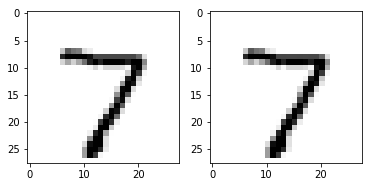

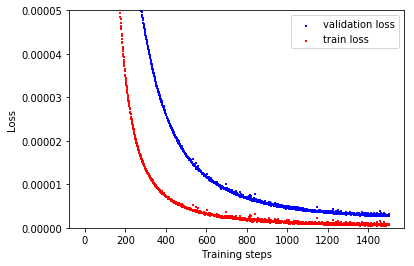

In [51]:
compression_ratio = test_data.shape[1]/size_hidden_2
validation_score,_,(ax1, ax2),fig = compression_analysis(compression_ratio)

In case for having $\color{green}{\text{500}}$ neurons in the latent layer, the compression ratio is 1.568. Except taking a bit longer time (larger than 1000 epochs, for validation loss to reach a stable decrease trend) it still gives a very good reconstruction of the input image. The validation loss is doubled compared to the case of having 784 neurons. Both of the roughly converged validation loss and training loss are above or around 0.00005 which is about five times more than last case.

mean validation loss 0.00043257896


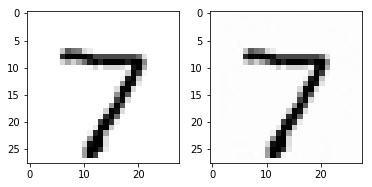

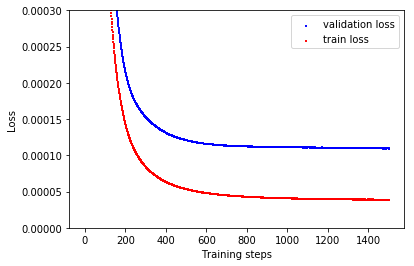

In [75]:
compression_ratio = test_data.shape[1]/size_hidden_2
validation_score,_,(ax1, ax2),fig = compression_analysis(compression_ratio)

In case for having $\color{green}{\text{300}}$ neurons in latent layer, the compression ratio is 2.261. The network seems to take shorter time, after 400 epochs,for training loss to get its stable decrease trend. But, looking at the validation loss around 200 epochs, there is sign of overfitting for the model. The complexity of network is not enough to learn critical features. The network tries to memorize the training data which is not meaningful for validation data. There is no overfitting in the case of having 500 neurons and 784 neurons in latent layer, since the network can do an identity mapping. The difference between training loss and validation loss, around 0.0004, gets larger compared to last example which is around 0.00008. The huge difference between training loss and validation can be one of the reasons for the overfitting. The visualized comparison between input and reconstructed image shows slight differences. In this case, a normalization or early stop should be applied. The mean validation loss is four times larger compared to last case. The minimum validation loss, 0.0013582223, is also being computed if an early stop is being an interest here.

mean validation loss 0.0017411599


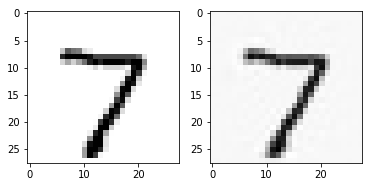

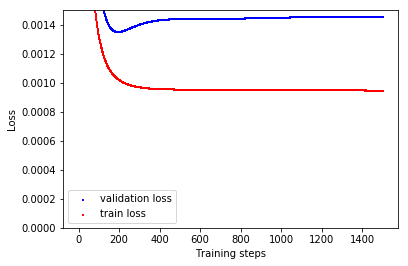

0.0013582223


In [98]:
compression_ratio = test_data.shape[1]/size_hidden_2
validation_score,_,(ax1, ax2),fig = compression_analysis(compression_ratio)
print(np.min(loss_validation))

In case for having $\color{green}{\text{200}}$ neurons in latent layer,the compression ratio is 3.92. Here, except longer learning time and larger difference between training loss and validation loss, there is also obvious visual differences between the reconstructed image and input image. Besides, roughly after 200 epochs, there is sign of overfitting for the model, since validation loss starts increase. However after 1000 epochs, the validation loss decreases again. The difference between validation loss and training loss grows into 0.0013 roughly. Here, the mean validation loss is only two times larger compared to the case of having 300 neurons in latent layer. 

mean validation loss 0.003928103


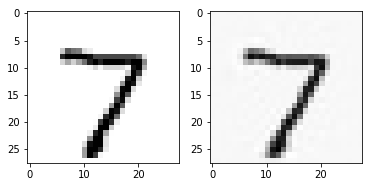

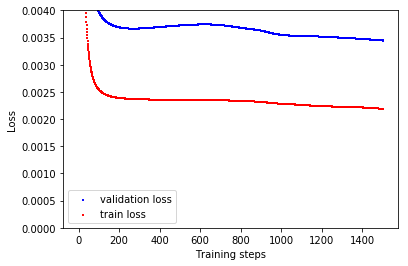

In [118]:
compression_ratio = test_data.shape[1]/size_hidden_2
validation_score,_,(ax1, ax2),fig = compression_analysis(compression_ratio)

In case for having $\color{green}{\text{100}}$ neurons in latent layer,the compression ratio is 7.84. Up to now, we used epoch of 1500. Based on comparison of training loss and validation loss, the network needs larger epochs to converge since both of training loss and validation tend to continue decrease,which testifies the complexity of network is not enough to learn critical features to represent the input image. The difference between training loss and validation loss gets very huge now. Overfitting also can be observed during epochs from 200 to 600.

mean validation loss 0.006935501


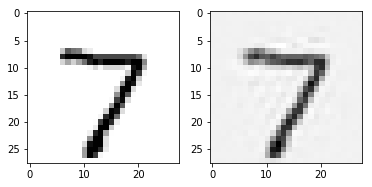

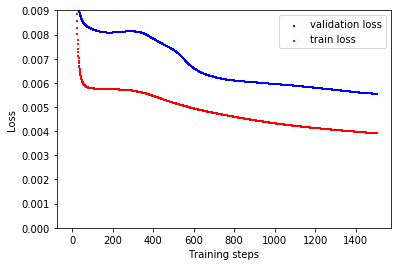

In [136]:
compression_ratio = test_data.shape[1]/size_hidden_2
validation_score, _,(ax1, ax2), fig = compression_analysis(compression_ratio)

To have an $\color{green}{\text{alternative way}}$ to improve complexity of network, we increase the size of hidden layer 1 from 1000 to 10000. The epoch is also increased to 60000. The learning rate is increased from 0.000008 to 0.000012 for a faster convergence. Compared to the last case, both of training loss and validation loss are far below 0.006. If one looks close enough, the reconstructed image looks more close to input image compared to last case as well. Also, the mean validation loss is almost only 60% of last case. It means, by increasing neurons in other layers but latent layer, the network can increase its complexity to solve the task for training data better as well. It is quite clear that both of losses show a vibration in decreasing trend. This is due to an exponential moving average of the gradient and the squared gradient which are calculated by Adam optimizer. 

mean validation loss 0.0040781773


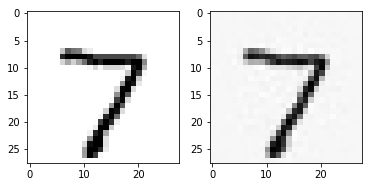

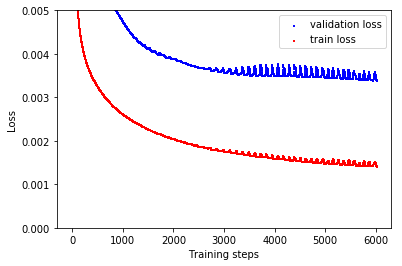

In [37]:
compression_ratio = test_data.shape[1]/size_hidden_2
validation_score, _,(ax1, ax2), fig = compression_analysis(compression_ratio)

## Part 3: Discussion 
Autoencoder is a simple neural network which delivers an output in a same size of input. The main function of autoencoder is to compress image and decompress it by which representing in a way as close as to the original image. The given example above is stacked autoencoder. There are others types of autoencoder based on the applications, such as data denoising autoencoder and variational aotoencoder. 

Following code-cell removes `In[]` / `Out[]` prompts left to code cells.

In [1]:
%%HTML
<style>div.prompt {display:none}</style>

---

<table>
  <tr>
    <td>Author:</td>
    <td>Buerlike Alai</td>
  </tr>
  <tr>
    <td>Last modified:</td>
    <td>01 / 07 / 2019</td>
  </tr>
</table> 